In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
# import seaborn as sns
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy

from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

from spike_statistics.core import permutation_resampling

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot, despine

08:44:53 [I] klustakwik KlustaKwik2 version 0.2.6


In [3]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

output_path = pathlib.Path("output") / "stimulus-response"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
output_path.mkdir(exist_ok=True)

In [4]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [5]:
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')

In [6]:
stim_action = actions['stimulus-response']
stim_results = pd.read_csv(stim_action.data_path('results'))

In [7]:
# lfp_results has old unit id's but correct on (action, unit_name, channel_group)
stim_results = stim_results.drop('unit_id', axis=1)

In [8]:
statistics_action = actions['calculate-statistics']
shuffling = actions['shuffling']

statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics_results = session_units.merge(statistics_results, how='left')
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics_results, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

In [9]:
data['unit_day'] = data.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

In [10]:
data = data.merge(stim_results, how='left')

In [11]:
waveform_action = actions['waveform-analysis']
waveform_results = pd.read_csv(waveform_action.data_path('results')).drop('template', axis=1)

In [12]:
data = data.merge(waveform_results, how='left')

In [13]:
colors = ['#d95f02','#e7298a']
labels = ['11 Hz', '30 HZ']
queries = ['frequency==11', 'frequency==30']

In [14]:
data.bs = data.bs.astype(bool)

In [15]:
data.loc[data.eval('t_i_peak == t_i_peak and not bs'), 'ns_inhibited'] = True
data.ns_inhibited.fillna(False, inplace=True)

data.loc[data.eval('t_i_peak != t_i_peak and not bs'), 'ns_not_inhibited'] = True
data.ns_not_inhibited.fillna(False, inplace=True)

In [16]:
query = (
    'gridness > gridness_threshold and '
    'information_rate > information_rate_threshold and '
    'gridness > .2 and '
    'average_rate < 25'
)
sessions_above_threshold = data.query(query)
print("Number of sessions above threshold", len(sessions_above_threshold))
print("Number of animals", len(sessions_above_threshold.groupby(['entity'])))

Number of sessions above threshold 194
Number of animals 4


In [17]:
gridcell_sessions = data[data.unit_day.isin(sessions_above_threshold.unit_day.values)]
print("Number of gridcells", gridcell_sessions.unit_idnum.nunique())
print("Number of gridcell recordings", len(gridcell_sessions))
print("Number of animals", len(gridcell_sessions.groupby(['entity'])))

Number of gridcells 139
Number of gridcell recordings 231
Number of animals 4


In [18]:
data.loc[:,'gridcell'] = np.nan
data['gridcell'] = data.isin(gridcell_sessions)

data.loc[data.eval('not gridcell and bs'), 'bs_not_gridcell'] = True
data.bs_not_gridcell.fillna(False, inplace=True)

In [19]:
data.query('baseline and Hz11 and gridcell').head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,half_width,peak_to_trough,average_firing_rate,bs,bs_stim,bs_ctrl,ns_inhibited,ns_not_inhibited,gridcell,bs_not_gridcell
33,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.272875,0.602667,5.945508,True,NaN,1.0,False,False,True,False
34,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.226452,0.274814,2.860048,False,NaN,0.0,False,True,True,False
35,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.247266,0.570104,3.365674,True,NaN,1.0,False,False,True,False
39,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.284542,0.644111,17.471520,True,NaN,1.0,False,False,True,False
40,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.259920,0.581698,5.891739,True,NaN,1.0,False,False,True,False


In [20]:
entity_date_ = data.query('stim_location!="ms" and stimulated').entity_date.unique()

In [21]:
data = data.query('stim_location!="ms" and entity_date in @entity_date_')

In [32]:
data.sort_values(['gridness'], ascending=False).loc[:, [
    'action', 'channel_group', 'unit_name', 'frequency', 'gridness', 'bs', 'ns', 'unit_day'
]]

,action,channel_group,unit_name,frequency,gridness,bs,ns,unit_day
1155,1834-110319-5,0,98,11.0,1.079689,True,NaN,332_110319
369,1834-110319-3,0,101,NaN,0.757034,True,NaN,332_110319
506,1834-110319-1,0,65,NaN,0.737920,True,NaN,332_110319
795,1834-110319-6,0,98,11.0,0.681349,True,NaN,342_110319
305,1849-010319-4,6,79,11.0,0.206625,True,NaN,895_010319
...,...,...,...,...,...,...,...,...
508,1834-110319-1,4,11,NaN,-0.791737,False,NaN,397_110319
303,1849-010319-4,3,73,11.0,-0.814508,True,NaN,779_010319
295,1849-010319-4,1,87,11.0,-0.861562,True,NaN,693_010319
512,1834-110319-1,6,20,NaN,-0.884116,True,NaN,459_110319


In [40]:
data.query('entity_date=="1849-010319"').loc[:, [
    'action', 'channel_group', 'unit_name', 'frequency', 'gridness', 'bs', 't_i_peak', 'stim_location'
]]

,action,channel_group,unit_name,frequency,gridness,bs,t_i_peak,stim_location
294,1849-010319-4,1,109,11.0,-0.537266,True,NaN,mecr
295,1849-010319-4,1,87,11.0,-0.861562,True,NaN,mecr
296,1849-010319-4,1,97,11.0,-0.569073,True,NaN,mecr
297,1849-010319-4,1,99,11.0,-0.690926,True,NaN,mecr
298,1849-010319-4,2,103,11.0,-0.604480,True,NaN,mecr
299,1849-010319-4,2,61,11.0,-0.207818,True,NaN,mecr
300,1849-010319-4,2,67,11.0,-0.446941,False,NaN,mecr
301,1849-010319-4,3,115,11.0,-0.522256,True,NaN,mecr
302,1849-010319-4,3,65,11.0,-0.432990,True,NaN,mecr
303,1849-010319-4,3,73,11.0,-0.814508,True,NaN,mecr


/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


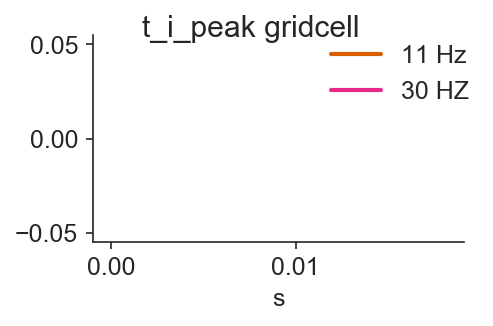

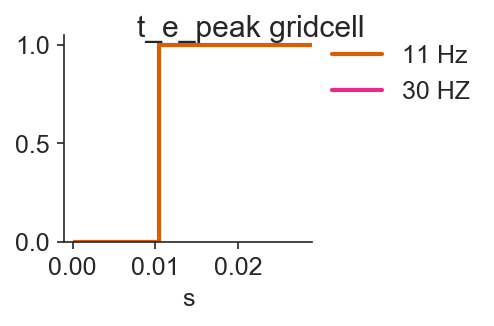

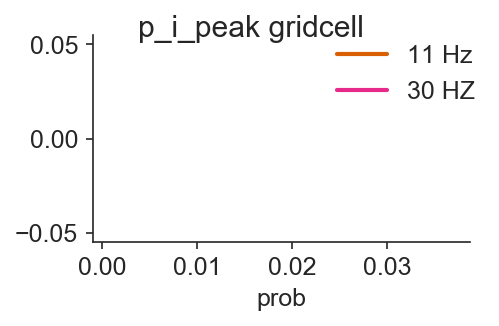

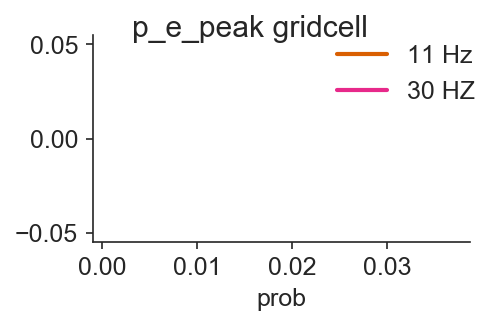

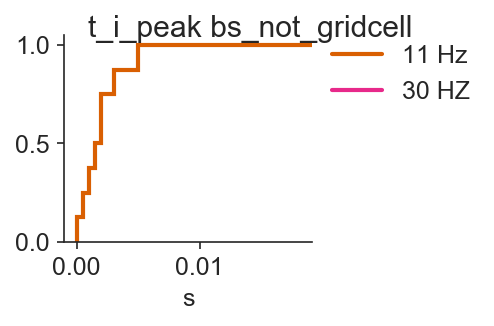

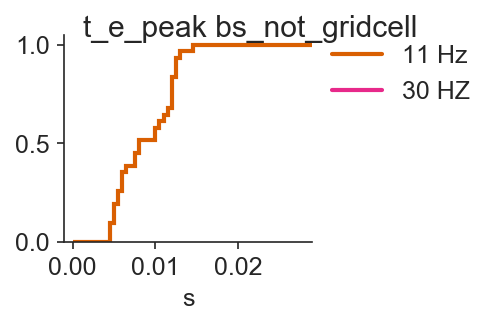

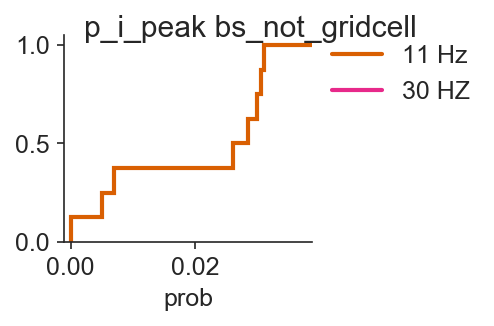

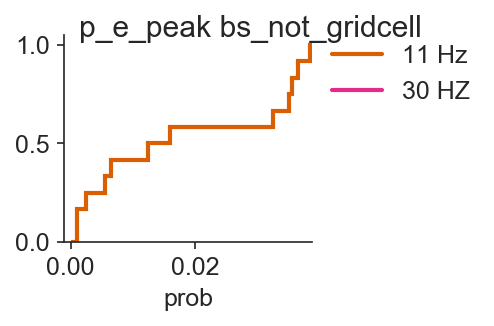

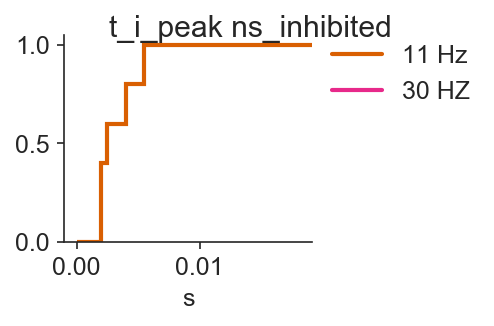

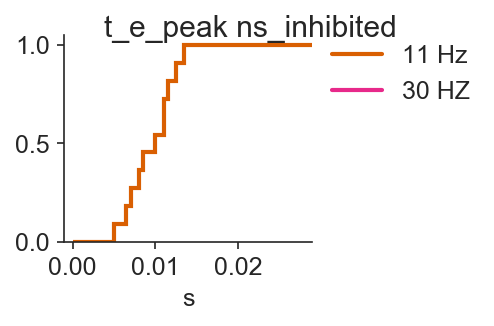

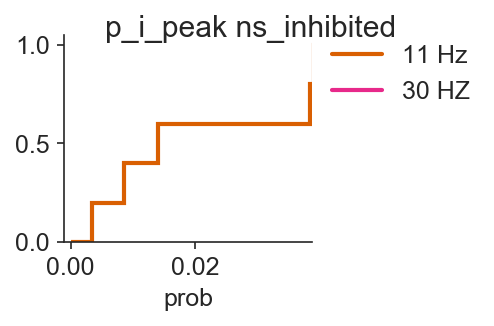

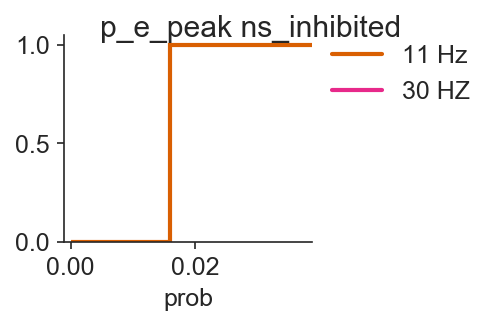

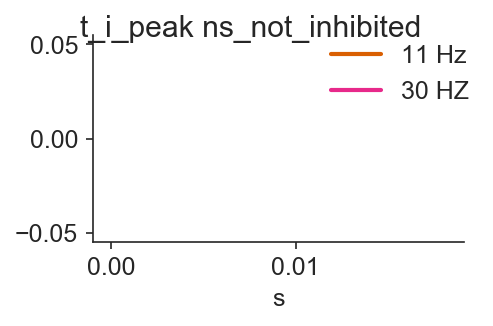

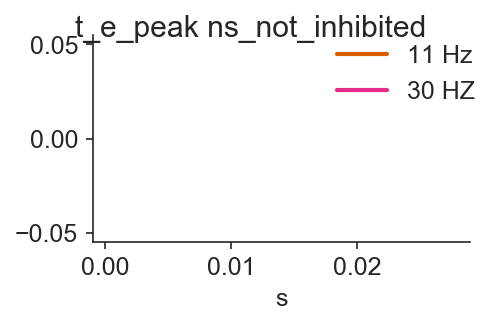

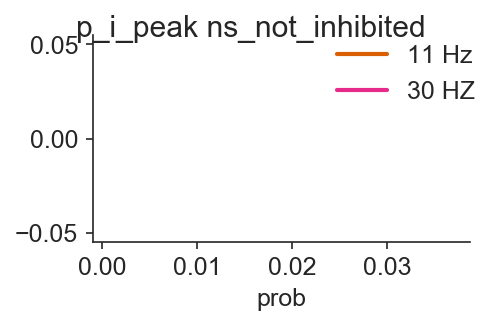

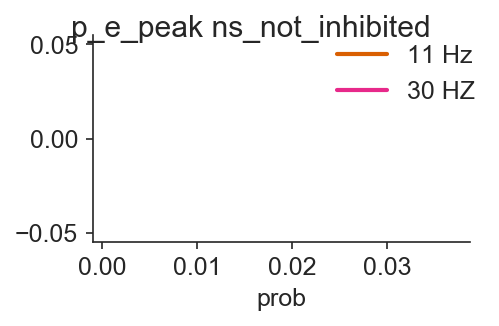

In [22]:

density = True
cumulative = True
histtype = 'step'
lw = 2
bins = {
    't_i_peak': np.arange(0, 0.02, 0.0005),
    't_e_peak': np.arange(0, 0.03, 0.0005),
    'p_i_peak': np.arange(0, 0.04, 0.0005),
    'p_e_peak': np.arange(0, 0.04, 0.0005),
}
xlabel = {
    't_i_peak': 's',
    't_e_peak': 's',
    'p_i_peak': 'prob',
    'p_e_peak': 'prob',
}

for cell_type in ['gridcell', 'bs_not_gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    for key in bins:
        fig = plt.figure(figsize=(3.5,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, query, label in zip(colors, queries, labels):
            data.query(query + ' and ' + cell_type)[key].hist(
                bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
                histtype=histtype, color=color)
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=lw, label=label))
        plt.xlabel(xlabel[key])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
        plt.xlim(-0.001, bins[key].max() - bins[key].max()*0.02)
        despine()
        figname = f'histogram-{key}-{cell_type}-stim-mec'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

In [23]:
from septum_mec.analysis.plotting import plot_bootstrap_timeseries

In [24]:
psth = pd.read_feather(output_path / 'data' / 'psth.feather')
times = pd.read_feather(output_path / 'data' / 'times.feather')

In [25]:
times = times.T.iloc[0].values

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


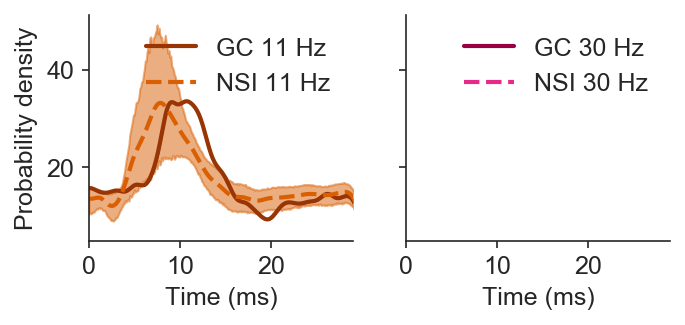

In [26]:
cs = ['#993404', '#980043', '#d95f02', '#e7298a']
lb = ['GC 11 Hz', 'GC 30 Hz', 'NSI 11 Hz', 'NSI 30 Hz']

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,2))
ii = 0
for cell_type, ls in zip(['gridcell', 'ns_inhibited'], ['-', '--']):
    for i, (ax, query) in enumerate(zip(axs.ravel(), queries)):
        selection = [
            f'{r.action}_{r.channel_group}_{r.unit_name}' 
            for i, r in data.query(query + ' and ' + cell_type).iterrows()]
        values = psth.loc[:, selection].dropna(axis=1).to_numpy()

        plot_bootstrap_timeseries(times*1000, values, ax=ax, lw=2, label=lb[ii], color=cs[ii], ls=ls)
    #     ax.set_title(titles[i])
        ax.set_xlabel('Time (ms)')
        ax.legend(frameon=False)
        ii += 1
    axs[0].set_ylabel('Probability density')
    despine()
    plt.xlim(0, 29)
    
figname = f'response-probability-gc-ns-stim-mec'
fig.savefig(
    output_path / 'figures' / f'{figname}.png', 
    bbox_inches='tight', transparent=True)
fig.savefig(
    output_path / 'figures' / f'{figname}.svg', 
    bbox_inches='tight', transparent=True)

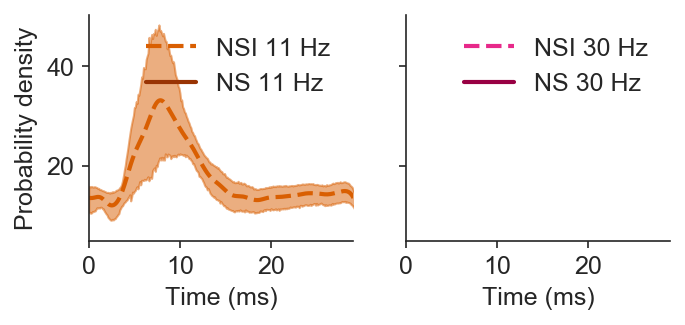

In [27]:
cs = ['#d95f02', '#e7298a', '#993404', '#980043']
lb = ['NSI 11 Hz', 'NSI 30 Hz', 'NS 11 Hz', 'NS 30 Hz']

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,2))
ii = 0
for cell_type, ls in zip(['ns_inhibited', 'ns_not_inhibited'], ['--', '-']):
    for i, (ax, query) in enumerate(zip(axs.ravel(), queries)):
        selection = [
            f'{r.action}_{r.channel_group}_{r.unit_name}' 
            for i, r in data.query(query + ' and ' + cell_type).iterrows()]
        values = psth.loc[:, selection].dropna(axis=1).to_numpy()

        plot_bootstrap_timeseries(times*1000, values, ax=ax, lw=2, label=lb[ii], color=cs[ii], ls=ls)
    #     ax.set_title(titles[i])
        ax.set_xlabel('Time (ms)')
        ax.legend(frameon=False)
        ii += 1
    axs[0].set_ylabel('Probability density')
    despine()
    plt.xlim(0, 29)
    
figname = f'response-probability-nsi-ns-stim-mec'
fig.savefig(
    output_path / 'figures' / f'{figname}.png', 
    bbox_inches='tight', transparent=True)
fig.savefig(
    output_path / 'figures' / f'{figname}.svg', 
    bbox_inches='tight', transparent=True)

# Store results in Expipe action

In [33]:
action = project.require_action("stimulus-response")

In [34]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/stimulus-response/data/data/times.feather',
 '/media/storage/expipe/septum-mec/actions/stimulus-response/data/data/psth.feather',
 '/media/storage/expipe/septum-mec/actions/stimulus-response/data/figures/histogram-t_i_peak-ns_inhibited.svg',
 '/media/storage/expipe/septum-mec/actions/stimulus-response/data/figures/histogram-p_e_peak-bs_not_gridcell.svg',
 '/media/storage/expipe/septum-mec/actions/stimulus-response/data/figures/histogram-t_i_peak-ns_not_inhibited.png',
 '/media/storage/expipe/septum-mec/actions/stimulus-response/data/figures/response-probability-nsi-ns.png',
 '/media/storage/expipe/septum-mec/actions/stimulus-response/data/figures/histogram-p_e_peak-gridcell.svg',
 '/media/storage/expipe/septum-mec/actions/stimulus-response/data/figures/histogram-p_e_peak-ns_inhibited.svg',
 '/media/storage/expipe/septum-mec/actions/stimulus-response/data/figures/histogram-t_e_peak-ns_inhibited.png',
 '/media/storage/expipe/septum-mec/actions/s

In [35]:
septum_mec.analysis.registration.store_notebook(action, "20_stimulus-spike-response.ipynb")